# Seam Carving

#### This project is a Python implementation of a seam carving algorithm, a technique for content-aware image resizing. Instead of uniformly scaling an image, this method intelligently finds and removes the least "interesting" paths of pixels, known as seams, to reduce the image's dimensions while preserving important features.

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

## Energy for each pixel


In [3]:
def energy_img(im): # the parameter is a MxNx3 (RGB) image.

  im_float = im.astype(np.float64) # changing the image type from uint8 to float64 allows for more precise calculations (especially in RGB weighing and gradient calculation)

  im_grey = (im_float[:,:,2] * 0.299 + im_float[:,:,1] * 0.587 + im_float[:,:,0] * 0.114) # weigh each color according to assignment instructions

  grad_y, grad_x = np.gradient(im_grey)

  im_energy = np.abs(grad_y) + np.abs(grad_x)

  return im_energy

## Cumulative Minimum Energy Map

In [4]:
def cumulative_min_energy_map(energyImg, seamDirection):

  height, width = energyImg.shape

  cum_map = np.zeros((height, width), dtype=np.float64)

  if seamDirection == 'VERTICAL':

    for i in range(height):
      for j in range (width):
        if i == 0:
          cum_map[i,j] = energyImg[i,j] # first row never changes because there is no row before it
        elif j == 0:
          cum_map[i,j] = energyImg[i,j] + min(cum_map[i-1, j], cum_map[i-1, j+1]) # left edge case
        elif j == width - 1:
          cum_map[i,j] = energyImg[i,j] + min(cum_map[i-1, j], cum_map[i-1, j-1]) # right edge case
        else:
          cum_map[i,j] = energyImg[i,j] + min(cum_map[i-1, j-1], cum_map[i-1, j], cum_map[i-1, j+1]) # find minimum value of the three pixels above current

  elif seamDirection == 'HORIZONTAL':

    for j in range(width):
      for i in range(height):
        if j == 0:
          cum_map[i,j] = energyImg[i,j] # first row never changes because there is no row before it
        elif i == 0:
          cum_map[i,j] = energyImg[i,j] + min(cum_map[i, j-1], cum_map[i+1, j-1]) # left edge case
        elif i == height - 1:
          cum_map[i,j] = energyImg[i,j] + min(cum_map[i, j-1], cum_map[i-1, j-1]) # right edge case
        else:
          cum_map[i,j] = energyImg[i,j] + min(cum_map[i-1, j-1], cum_map[i, j-1], cum_map[i+1, j-1]) # find minimum value of the three pixels to the right of current

  return cum_map



## Finding Vertical and Horizontal Seams

In [5]:
def find_vertical_seam(cumulativeEnergyMap): #to compute the optimal vertical seam

  height, width = cumulativeEnergyMap.shape
  seam = []
  min_energy = float('inf')

  for j in range(width): # find j value with the minimum energy (starting point of seam)
    if cumulativeEnergyMap[height - 1, j] < min_energy:
      min_energy = cumulativeEnergyMap[height - 1, j]
      min_j = j

  seam.append(min_j) # append starting point to seam list

  for i in range(height - 2, -1, -1): # go from bottom to top
    if min_j == 0: #j is on the left edge of the image
      if cumulativeEnergyMap[i, min_j + 1] < cumulativeEnergyMap[i, min_j]:
        min_j = min_j + 1

    elif min_j == width - 1: #j is on the right edge of the image
      if cumulativeEnergyMap[i, min_j - 1] < cumulativeEnergyMap[i, min_j]:
        min_j = min_j - 1

    else:
      if (cumulativeEnergyMap[i, min_j - 1] <= cumulativeEnergyMap[i, min_j] and
        cumulativeEnergyMap[i, min_j - 1] <= cumulativeEnergyMap[i, min_j + 1]): # left pixel is minimum
        min_j = min_j - 1
      elif (cumulativeEnergyMap[i, min_j + 1] <= cumulativeEnergyMap[i, min_j] and
        cumulativeEnergyMap[i, min_j + 1] <= cumulativeEnergyMap[i, min_j - 1]): # right pixel is minimum
        min_j = min_j + 1

    seam.append(min_j)

  return seam[::-1]



def find_horizontal_seam(cumulativeEnergyMap): #to compute the optimal horizontal seam

  height, width = cumulativeEnergyMap.shape
  seam = []
  min_energy = float('inf')

  for i in range(height): # find i value with the minimum energy (starting point of seam)
    if cumulativeEnergyMap[i, width - 1] < min_energy:
      min_energy = cumulativeEnergyMap[i, width - 1]
      min_i = i

  seam.append(min_i) # append starting point to seam list

  for j in range(width - 2, -1, -1): # go from right to left
    if min_i == 0: #i is on the top edge of the image
      if cumulativeEnergyMap[min_i + 1, j] < cumulativeEnergyMap[min_i, j]:
        min_i = min_i + 1

    elif min_i == height - 1: #i is on the bottom edge of the image
      if cumulativeEnergyMap[min_i - 1, j] < cumulativeEnergyMap[min_i, j]:
        min_i = min_i - 1

    else:
      if (cumulativeEnergyMap[min_i - 1, j] <= cumulativeEnergyMap[min_i, j] and
          cumulativeEnergyMap[min_i - 1, j] <= cumulativeEnergyMap[min_i + 1, j]): # top pixel is minimum
        min_i = min_i - 1
      elif (cumulativeEnergyMap[min_i + 1, j] <= cumulativeEnergyMap[min_i, j] and
            cumulativeEnergyMap[min_i + 1, j] <= cumulativeEnergyMap[min_i - 1, j]): # bottom pixel is minimum
        min_i = min_i + 1

    seam.append(min_i)

  return seam[::-1]


In [6]:
def view_seam(im, seam, seamDirection):

  plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))

  if seamDirection == 'VERTICAL':

    y = np.arange(im.shape[0])
    x = np.array(seam)
    plt.plot(x, y, color='red')
    plt.title('Optimal Vertical Seam')

  elif seamDirection == 'HORIZONTAL':

    x = np.arange(im.shape[1])
    y = np.array(seam)
    plt.plot(x, y, color='red')
    plt.title('Optimal Horizontal Seam')

  plt.show()

## Decrease Height and Width


In [7]:
def decrease_width(im, energyImg):

  height, width = im.shape[:2]

  cum_map = cumulative_min_energy_map(energyImg, 'VERTICAL')
  seam = find_vertical_seam(cum_map)

  reduced_im = np.zeros((height, width - 1, 3), dtype=np.uint8) # create new blank image
  reduced_energy = np.zeros((height, width - 1), dtype=np.float64) # create new blank energy image

  for i in range(height):

    removed_column = seam[i]  #find column index to remove

    reduced_im[i, :] = np.delete(im[i, :], removed_column, axis = 0) # remove pixel at index of seam

    reduced_energy[i, :] = np.delete(energyImg[i, :], removed_column, axis = 0)

  return reduced_im, reduced_energy


def decrease_height(im, energyImg):

  height, width = im.shape[:2]

  cum_map = cumulative_min_energy_map(energyImg, 'HORIZONTAL')
  seam = find_horizontal_seam(cum_map)

  reduced_im = np.zeros((height - 1, width, 3), dtype=np.uint8)
  reduced_energy = np.zeros((height - 1, width), dtype=np.float64)

  for j in range(width):

    removed_row = seam[j]

    reduced_im[:, j] = np.delete(im[:, j], removed_row, axis = 0)

    reduced_energy[:, j] = np.delete(energyImg[:, j], removed_row, axis = 0)

  return reduced_im, reduced_energy


## 1. & 2. Resize Images

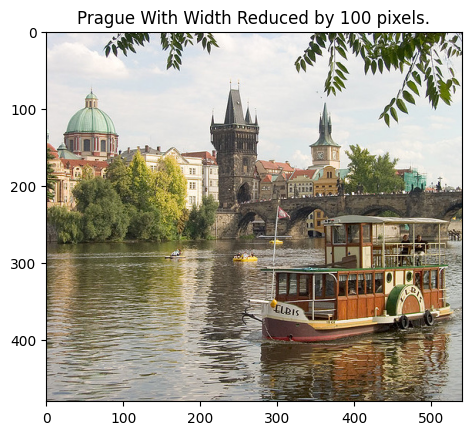

In [11]:
im  = cv2.imread('inputSeamCarvingPrague.jpg')
if im is None: # check to see if the image was loaded
    print("Error: Could not load image. Please make sure 'inputSeamCarvingPrague.jpg' is in the correct directory.")
else:
    reduced_im_width = im.copy() # make a copy to avoid modifying the original image
    reduced_energy_width = energy_img(im)

    for i in range(100):
      reduced_im_width, reduced_energy_width = decrease_width(reduced_im_width, reduced_energy_width) # this process can take a little less than a minute to finish

    plt.imshow(cv2.cvtColor(reduced_im_width, cv2.COLOR_BGR2RGB))
    plt.title("Prague With Width Reduced by 100 pixels.")
    cv2.imwrite('outputReduceWidthPrague.png', reduced_im_width)
    plt.show()

True

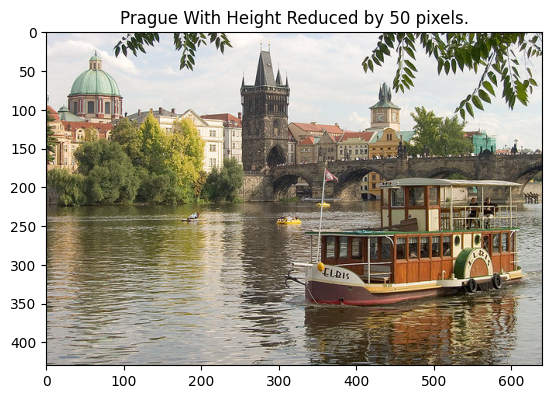

In [12]:
reduced_im_height = im
reduced_energy_height = energy_img(im)

for i in range(50):
  reduced_im_height, reduced_energy_height = decrease_height(reduced_im_height, reduced_energy_height) # note that a single image can take about 30 seconds to process

plt.imshow(cv2.cvtColor(reduced_im_height, cv2.COLOR_BGR2RGB))
plt.title("Prague With Height Reduced by 50 pixels.")
cv2.imwrite('outputReduceHeightPrague.png', reduced_im_height)
plt.show()

True

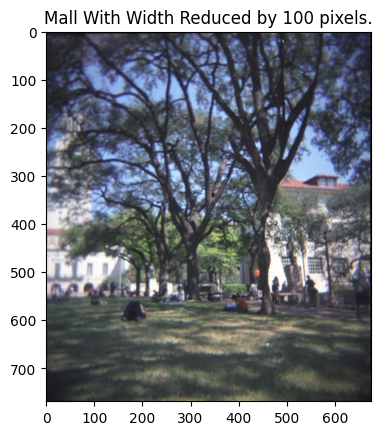

In [14]:
im  = cv2.imread('inputSeamCarvingMall.jpg')
if im is None:
    print("Error: Could not load image. Please make sure 'inputSeamCarvingMall.jpg' is in the correct directory.")

reduced_im_width = im
reduced_energy_width = energy_img(im)

for i in range(100):
  reduced_im_width, reduced_energy_width = decrease_width(reduced_im_width, reduced_energy_width) # this process can take a little less than a minute to finish

plt.imshow(cv2.cvtColor(reduced_im_width, cv2.COLOR_BGR2RGB))
plt.title("Mall With Width Reduced by 100 pixels.")
cv2.imwrite('outputReduceWidthMall.png', reduced_im_width)
plt.show()

True

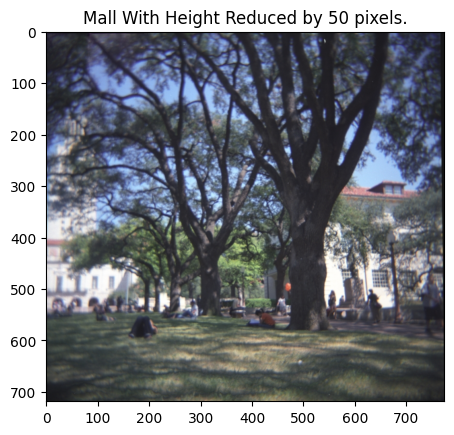

In [15]:
reduced_im_height = im
reduced_energy_height = energy_img(im)

for i in range(50):
  reduced_im_height, reduced_energy_height = decrease_height(reduced_im_height, reduced_energy_height) # note that a single image can take about 30 seconds to process

plt.imshow(cv2.cvtColor(reduced_im_height, cv2.COLOR_BGR2RGB))
plt.title("Mall With Height Reduced by 50 pixels.")
cv2.imwrite('outputReduceHeightMall.png', reduced_im_height)
plt.show()

# 3. Energy Maps

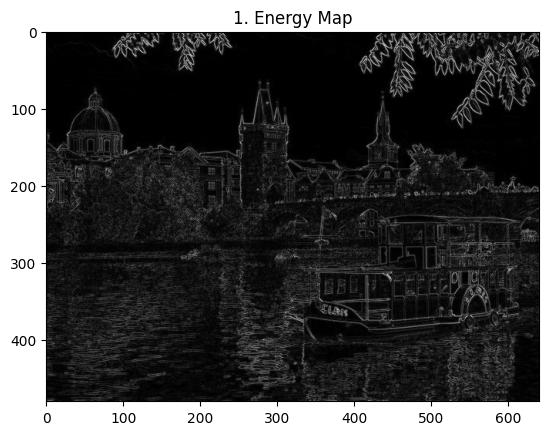

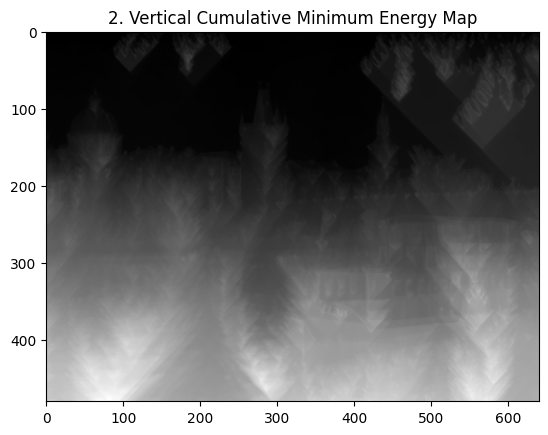

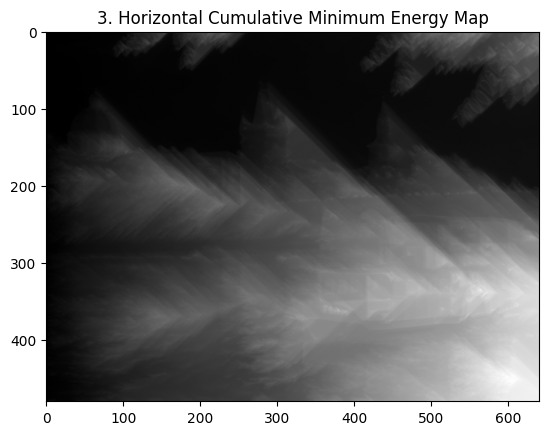

In [16]:
im = cv2.imread('inputSeamCarvingPrague.jpg')
energy_map = energy_img(im)

vert_cum_map = cumulative_min_energy_map(energy_map, 'VERTICAL')
horiz_cum_map = cumulative_min_energy_map(energy_map, 'HORIZONTAL')

plt.imshow(energy_map, cmap='gray')
plt.title('1. Energy Map')
plt.show()

plt.imshow(vert_cum_map, cmap='gray')
plt.title('2. Vertical Cumulative Minimum Energy Map')
plt.show()

plt.imshow(horiz_cum_map, cmap='gray')
plt.title('3. Horizontal Cumulative Minimum Energy Map')
plt.show()

As can be seen in the images above, the cumulative energy maps represent the paths where the total cumulative energy is higher (brighter) and lower (darker). In the Vertical Cumulative Minimum Energy Map (2), we can see that path costs are very low until about halfway through the map. The darkest pixel in the lowermost row is part of the seam we want to remove. If we compare the ideal vertical seam (4) with this map, we can see that the ideal seam falls right in the darkest areas within this map.

The Horizontal Cumulative Minimum Energy Map shows the same concept but from left to right. We can see that the darkest pixels in the rightmost side indicate the end of paths with the least cumulative energy. Comparing this map to the ideal horizontal seam, it also falls right within the darkest area.

## 4. Viewing the seams

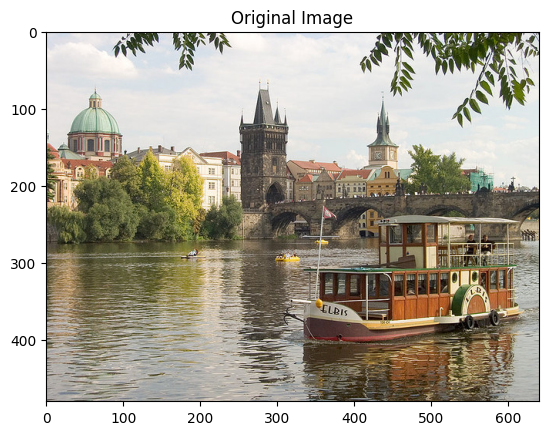

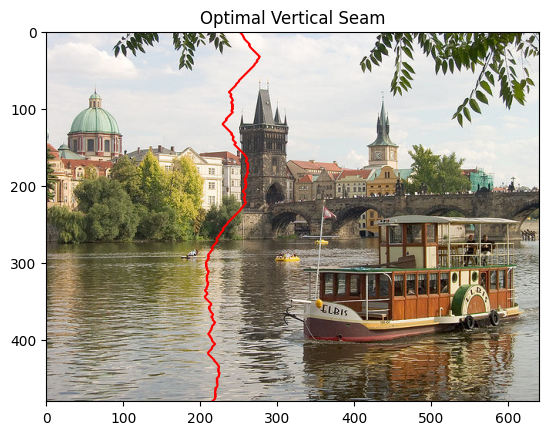

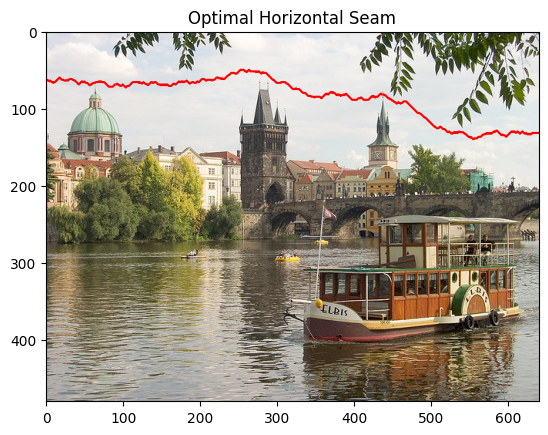

In [17]:
energyImg = energy_img(im) #to compute the energy at each pixel using the magnitude of the x and y gradients

cumulativeEnergyMap = cumulative_min_energy_map(energyImg, 'VERTICAL') #to compute minimum cumulative energy

verticalSeam = find_vertical_seam(cumulativeEnergyMap) #to compute the optimal vertical seam

cumulativeEnergyMap = cumulative_min_energy_map(energyImg, 'HORIZONTAL') #to compute minimum cumulative energy

horizontalSeam = find_horizontal_seam(cumulativeEnergyMap) #to compute the optimal horizontal seam

plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.show()

view_seam(im,verticalSeam,'VERTICAL') #to display the selected type of seam on top of an image

view_seam(im,horizontalSeam,'HORIZONTAL')


As discussed in the previous section (3), the seams indicate the past where the cumulative energy is the lowest. To compute that, we start from up to down and right to left, where we can select the pixel in the upmost (if vertical seam) row or rightmost (if horizontal seam) column with the lowest value, and travel backwards from there finding always the lowest preceding pixel value. This allows us to find a seam that is considered by this method the "least interesting" seam in the image. Comparing with the previously shown cumulative energy maps, we can see that these seams fall exactly where the map shows a lower cumulative energy when compared to other parts of the map.

# 5. Modified Energy Function



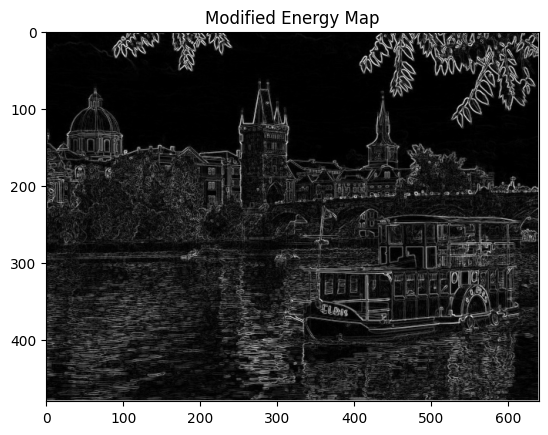

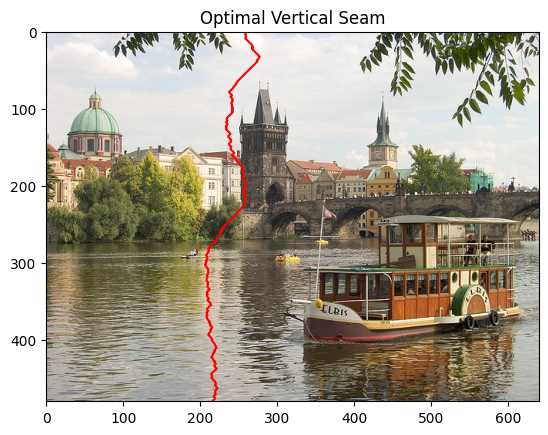

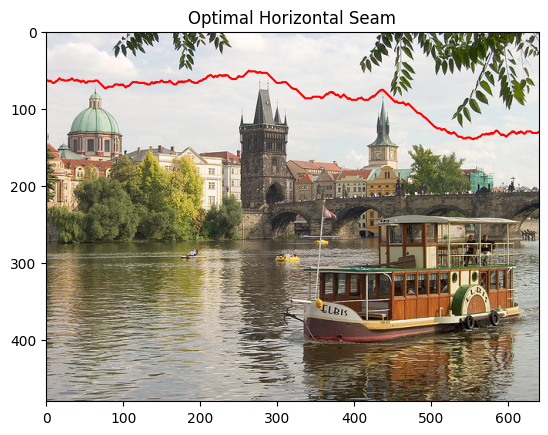

In [21]:
def mod_energy_img(im): # this function is a modified version of my previously implemented new_energy_img function
                        # that computes the energy at each pixel with Sobel kernels

  im_float = im.astype(np.float64)

  im_grey = (im_float[:,:,2] * 0.299 + im_float[:,:,1] * 0.587 + im_float[:,:,0] * 0.114)

  sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])

  sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

  def convolve(image, kernel): # helper function to slide the kernal over each pixel

    height, width = image.shape
    kernel_height, kernel_width = kernel.shape
    output = np.zeros((height, width), dtype=np.float64)
    padding = kernel_width // 2 # width is usually 3 so padding is usually 1

    for i in range(padding, height - padding): # for every pixel within the padded area
      for j in range(padding, width - padding):
        output[i, j] = np.sum(image[i - padding:i + padding + 1, j - padding:j + padding + 1] * kernel) # apply kernel to that pixel


    return output # return the output of the convolution

  grad_x = convolve(im_grey, sobel_x)
  grad_y = convolve(im_grey, sobel_y)

  im_energy = np.abs(grad_y) + np.abs(grad_x) # calculate the energy map

  # set the borders of the energy map to a high value (this prevents a bug where seams choose image borders)
  im_energy[0, :] = 1000
  im_energy[-1, :] = 1000
  im_energy[:, 0] = 1000
  im_energy[:, -1] = 1000

  return im_energy

im = cv2.imread('inputSeamCarvingPrague.jpg') # load the image here

mod_energy_map = mod_energy_img(im)

plt.imshow(mod_energy_map, cmap='gray')
plt.title('Modified Energy Map')
plt.show()

cumulativeEnergyMap = cumulative_min_energy_map(mod_energy_map, 'VERTICAL') #to compute minimum cumulative energy

verticalSeam = find_vertical_seam(cumulativeEnergyMap) #to compute the optimal vertical seam

cumulativeEnergyMap = cumulative_min_energy_map(mod_energy_map, 'HORIZONTAL') #to compute minimum cumulative energy

horizontalSeam = find_horizontal_seam(cumulativeEnergyMap) #to compute the optimal horizontal seam

view_seam(im,verticalSeam,'VERTICAL') #to display the selected type of seam on top of an image

view_seam(im,horizontalSeam,'HORIZONTAL')

Whereas the first energy map function calculated the gradient based on two subsequent pixels, the modified funcition applies a sobel kernel over the immediate neighborhood around the selected kernel. As can be seen when comparing both outputs, the modified version provides much more defined lines and more robust edge detection. The sobel kernel gives more weight to pixels closer to the center, providing more clearly defined lines, as can be seen in the tree leaves, especially. In this case the chosen seams are extremely similar, likely because they are indubitably the paths with least energy.

## 6. Testing With Different Images

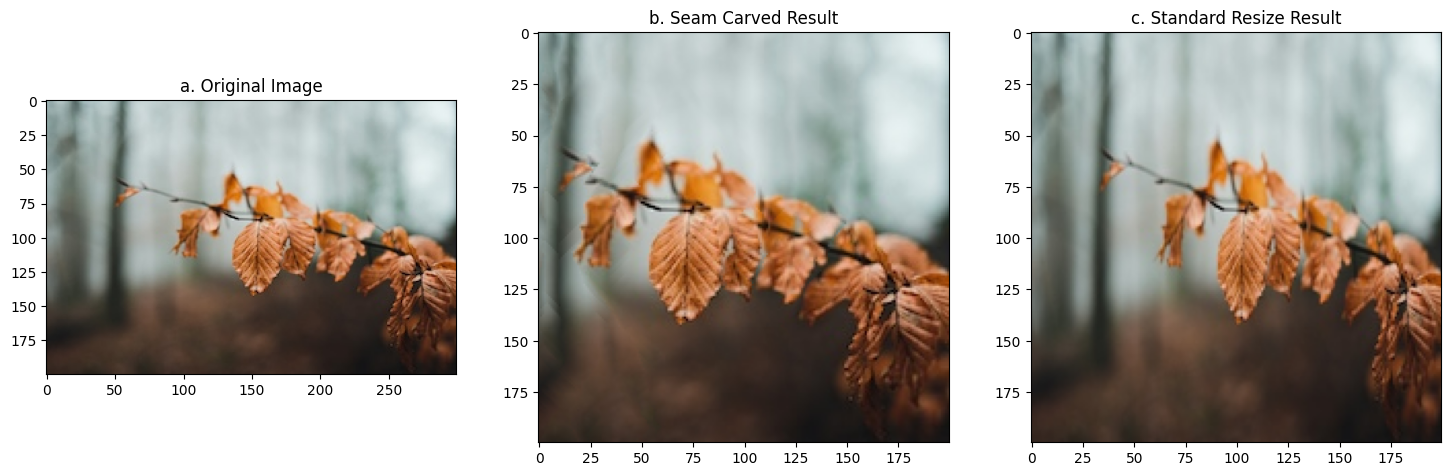

In [30]:
image_filename = 'branch.jpg'
num_seams = 100
direction = 'VERTICAL'

original_im = cv2.imread(image_filename)
im_to_carve = np.copy(original_im)

for i in range(num_seams):
  # recalculate the energy map for the current image in each iteration
  energy_map = energy_img(im_to_carve)
  if direction == 'VERTICAL':
    im_to_carve, energy_map = decrease_width(im_to_carve, energy_map)
  else:
    im_to_carve, energy_map = decrease_height(im_to_carve, energy_map)

h, w = original_im.shape[:2]
if direction == 'VERTICAL':
  target_size = (w - num_seams, h)
else:
  target_size = (w, h - num_seams)
standard_resize = cv2.resize(original_im, target_size)

plt.figure(figsize=(18, 7))
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(original_im, cv2.COLOR_BGR2RGB))
plt.title('a. Original Image')
plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(im_to_carve, cv2.COLOR_BGR2RGB))
plt.title('b. Seam Carved Result')
plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(standard_resize, cv2.COLOR_BGR2RGB))
plt.title('c. Standard Resize Result')
plt.show()

As can be seen, our seam carver result (b) leaves the branch in as the main subject of the image, whereas the standard resize (c) simply compresses everything and distorts the shapes. The seam carved result works better here because the leftmost part of the image is not seen as "interesting" by the cumulative gradient map, so most of it gets removed from the picture. Note that the trees in the background of the seam carved result can appear slightly distorted.

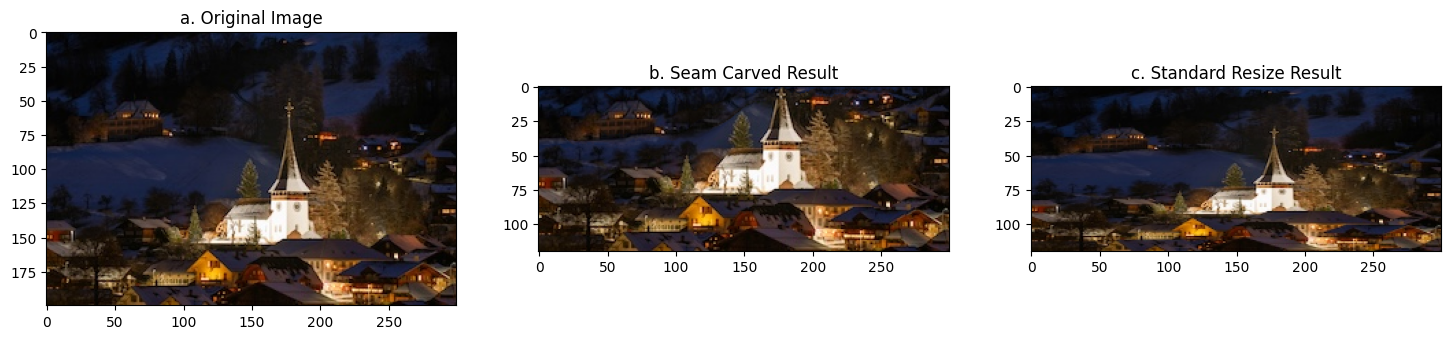

In [31]:
image_filename = 'town.jpg'
num_seams = 80
direction = 'HORIZONTAL'

original_im = cv2.imread(image_filename)
im_to_carve = np.copy(original_im)

for i in range(num_seams):
  # recalculate the energy map for the current image in each iteration
  energy_map = energy_img(im_to_carve)
  if direction == 'VERTICAL':
    im_to_carve, energy_map = decrease_width(im_to_carve, energy_map)
  else:
    im_to_carve, energy_map = decrease_height(im_to_carve, energy_map)

h, w = original_im.shape[:2]
if direction == 'VERTICAL':
  target_size = (w - num_seams, h)
else:
  target_size = (w, h - num_seams)
standard_resize = cv2.resize(original_im, target_size)

plt.figure(figsize=(18, 7))
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(original_im, cv2.COLOR_BGR2RGB))
plt.title('a. Original Image')
plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(im_to_carve, cv2.COLOR_BGR2RGB))
plt.title('b. Seam Carved Result')
plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(standard_resize, cv2.COLOR_BGR2RGB))
plt.title('c. Standard Resize Result')
plt.show()

Now by resizing the image's height, we can see a big difference in how the image's subjects appear when the seam carved result is compared to the standard resize result. Result 'b' shows much better preservation of houses and the church, whereas result 'c' shows too much of the snow and trees above.

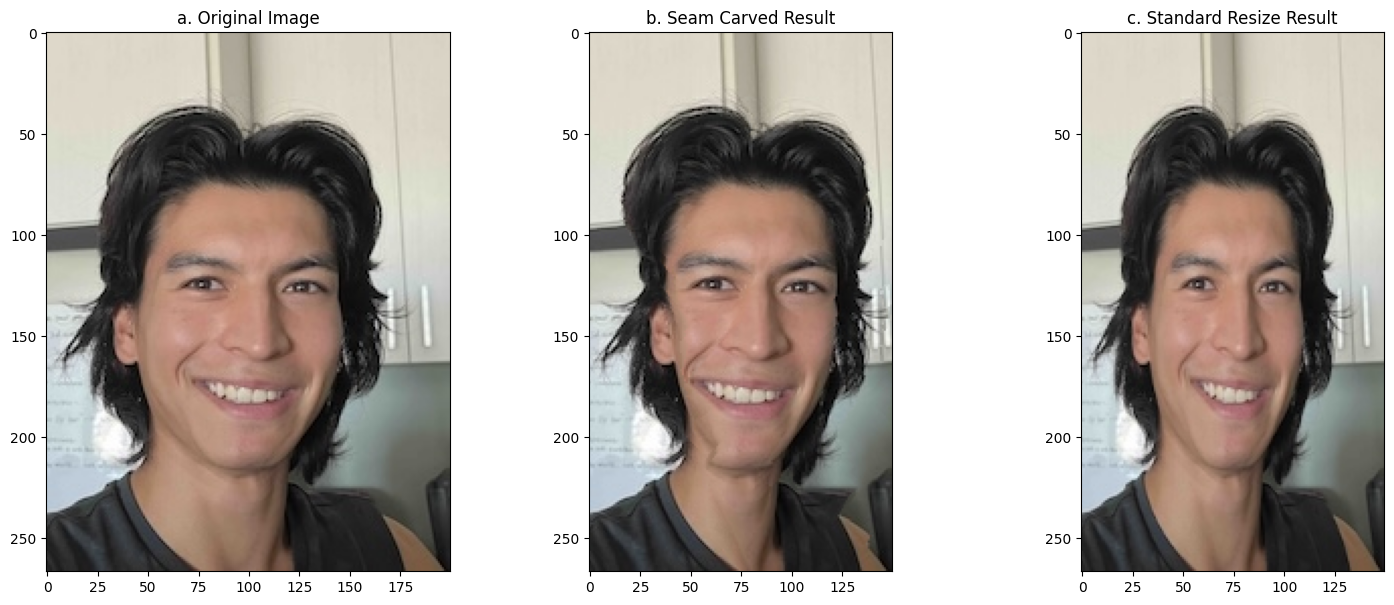

In [26]:
image_filename = 'mirado.jpg'
num_seams = 50
direction = 'VERTICAL'

original_im = cv2.imread(image_filename)
im_to_carve = np.copy(original_im)

for i in range(num_seams):
  # recalculate the energy map for the current image in each iteration
  energy_map = energy_img(im_to_carve)
  if direction == 'VERTICAL':
    im_to_carve, energy_map = decrease_width(im_to_carve, energy_map)
  else:
    im_to_carve, energy_map = decrease_height(im_to_carve, energy_map)

h, w = original_im.shape[:2]
if direction == 'VERTICAL':
  target_size = (w - num_seams, h)
else:
  target_size = (w, h - num_seams)
standard_resize = cv2.resize(original_im, target_size)

plt.figure(figsize=(18, 7))
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(original_im, cv2.COLOR_BGR2RGB))
plt.title('a. Original Image')
plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(im_to_carve, cv2.COLOR_BGR2RGB))
plt.title('b. Seam Carved Result')
plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(standard_resize, cv2.COLOR_BGR2RGB))
plt.title('c. Standard Resize Result')
plt.show()

In this image, my friend Mirado was the subject of what I already knew would be a "failure" case of the seam carved result. When the subject makes up a big part of the image, the seam often goes through it, creating distortions. This is a case where a standard resizing (c) works a lot better at preserving the shape of the subject. It is interesting to note, however, that the eyes, nose, mouth, and ears are almost entirely preserved, whereas the low-energy skin is removed.